In [1]:
import librosa
import numpy as np
import itertools
from matplotlib import pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from pydub import AudioSegment
from scipy import signal
from sklearn import preprocessing

In [2]:
pathAudio = 'C:/Users/Admin/OneDrive/Dokumente/Studium/Technology Lab/Technology Lab Team 4/Techno Titel/train/samples-stochastic/'
files = librosa.util.find_files(pathAudio, ext=['mp3'])

song_lounge_it = []
song_tuesday_night = []
song_kingtop = []
for file in files:
    if 'Maarten Schellekens - Lounge It' in file:
        song_lounge_it.append(file)
    if 'Maarten Schellekens - Tuesday Night Radio Edit' in file:
        song_tuesday_night.append(file)
    if 'Tea K Pea - kingtop' in file:
        song_kingtop.append(file)
song_lounge_it = sorted(song_lounge_it, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_tuesday_night = sorted(song_tuesday_night, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_kingtop = sorted(song_kingtop, key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [3]:
print(len(song_lounge_it))
print(len(song_tuesday_night))
print(len(song_kingtop))

126
43
74


In [4]:
full_songs = []
full_songs.extend(song_lounge_it)
full_songs.extend(song_tuesday_night)
full_songs.extend(song_kingtop)
len(full_songs)

243

In [5]:
# todo: Check smallest sample!!
def normalize_sample(sample):
    array_of_samples = sample.get_array_of_samples()
    np_arr = np.array(array_of_samples)
    np_arr = np_arr.reshape(1, -1)
    return preprocessing.normalize(np_arr)


samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    resampled_sample = signal.resample(normalized_sample, int(len(normalized_sample)/35))
    samples.append(resampled_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, int(len(normalized_sample)/35))
    samples_sec_canal.append(resampled_sample_sec_canal)

In [12]:
len(samples[0])

2579

In [7]:
edge_size = min(map(len, samples))

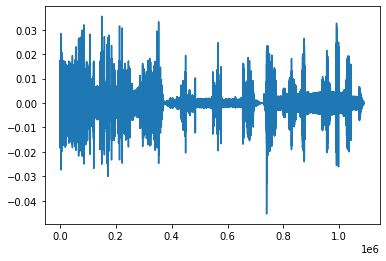

In [8]:
plt.plot(list(itertools.chain.from_iterable(samples)))
plt.show()

In [28]:
X_train = []
Y_train = []
for i in range(len(samples)-2):
    if i == 0:
        first_half = list(samples[i][-1500:])
    else:
        ref_samp = list(samples[i-1]) + list(samples[i])
        if len(ref_samp) < 1500:
            ref_samp_2 = list(samples[i-2]) + list(samples[i-1]) + list(samples[i])
            first_half = list(ref_samp_2[-1500:])
        else:
            first_half = list(ref_samp[-1500:])
    X_train.append(first_half)
    last_ref = list(samples[i+1]) + list(samples[i+2])
    last_half = list(last_ref[:500])
    Y_train.append(last_half)

In [29]:
min(map(len, X_train))

1500

In [30]:
len(X_train)

241

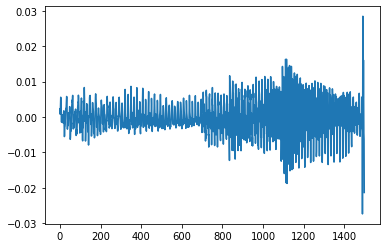

In [31]:
plt.plot(X_train[1])
plt.show()

In [32]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 1500)
X_train.shape

(241, 1500)

In [33]:
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1, 500)
Y_train.shape

(241, 500)

In [86]:
from keras.layers import Conv1D, LSTM, Flatten

model = Sequential()
model.add(Conv1D(filters=1000, kernel_size=1, input_shape=(1500, 1)))
model.add(LSTM(500))
model.add(Dense(500))
model.add(Flatten())
model.add(Dense(500))

model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1500, 100)         200       
                                                                 
 lstm_4 (LSTM)               (None, 200)               240800    
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 500)               100500    
                                                                 
Total params: 381,700
Trainable params: 381,700
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
8/8 [==============================] - 31s 4s/step - loss: 3.2680e-05
Epoch 2/10
8/8 [==============================] - 30s 4s/step - loss: 2.1380e-05
Epoch 3/10
8/8 [==============================] - 32s 4s/step - loss: 2.1526e-05
Epoch 4/10
8/8 [==============================] - 31s 4s/step - loss: 2.1020e-05
Epoch 5/10
8/8 [==============================] - 31s 4s/step - loss: 2.1810e-05
Epoch 6/10
8/8 [==============================] - 31s 4s/step - loss: 2.1529e-05
Epoch 7/10
8/8 [==============================] - 31s 4s/step - loss: 2.1244e-05
Epoch 8/10
8/8 [==============================] - 31s 4s/step - loss: 2.0492e-05
Epoch 9/10
8/8 [==============================] - 31s 4s/step - loss: 2.1400e-05
Epoch 10/10
8/8 [==============================] - 31s 4s/step - loss: 2.1318e-05


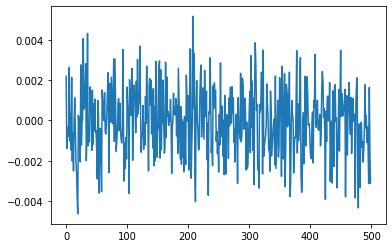

In [94]:
nr = 4
example_x_train = X_train[nr]
example_x_train_res = example_x_train.reshape(1, 1500)
pred = model.predict(example_x_train_res)
plt.plot(pred[0])
plt.show()

In [ ]:
plt.plot(list(example_x_train)+list(samples[nr+1][:500]))
plt.show()
plt.plot(list(example_x_train)+list(pred[0]))
plt.show()